 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Python-Setup" data-toc-modified-id="Python-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python Setup</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Database-for-storing-simulation-results" data-toc-modified-id="Database-for-storing-simulation-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Database for storing simulation results</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Plotting-functions" data-toc-modified-id="Plotting-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plotting functions</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Class-for-creating-and-running-simulations" data-toc-modified-id="Class-for-creating-and-running-simulations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Class for creating and running simulations</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Running-simulations" data-toc-modified-id="Running-simulations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running simulations</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Error-estimation" data-toc-modified-id="Error-estimation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Error estimation</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Error-analysis" data-toc-modified-id="Error-analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Error analysis</a></span></li><li><span><a href="http://localhost:8889/notebooks/RunAnalyzeSTE.ipynb#Extracting-data-database-and-plotting" data-toc-modified-id="Extracting-data-database-and-plotting-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Extracting data database and plotting</a></span></li></ul></div>

# Python Setup

In [990]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:95% !important;} </style>"))
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("pgf")
pgf_with_rc_fonts = {
   "pgf.rcfonts" : False
}
mpl.rcParams.update(pgf_with_rc_fonts)
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import glob
import numpy as np
from scipy import constants as const
import datetime as dt
import os
from collections import OrderedDict
import functools 
import subprocess
import sys

#progress bar
from IPython.display import display  
from ipywidgets import FloatProgress  
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/tmerten/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Database for storing simulation results

In [438]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import os
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Column, Integer, String, DateTime, Float
from sqlalchemy import exists

dbpath = '/home/tmerten/data/IBS/simadata/'
dbfile = 'bessyII.db'

if not os.path.exists( dbpath ):
    os.mkdir( dbpath )
    
engine = create_engine("sqlite:///" +  dbpath + dbfile )

Base = declarative_base()

class Intensity(Base):
    __tablename__ = 'intensity'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    NMacro = Column(Integer)
    Current = Column(Float)
    NReal = Column(Float)
    NRealLost = Column(Float)
    Ttou = Column(Float)
    
class Emit(Base):
    __tablename__ = 'emit'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    ex = Column(Float)
    sigpx = Column(Float)
    ey = Column(Float)
    sigpy = Column(Float)
    sigs = Column(Float)
    sige = Column(Float)

class Ibs(Base):
    __tablename__ = 'ibs'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    Tex = Column(Float)
    Tey = Column(Float)
    Tp = Column(Float)
    
class Equilib(Base):
    __tablename__= 'equi'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    equix = Column(Float)
    equiy = Column(Float)
    equis = Column(Float)
    
Base.metadata.create_all(engine)
inspector = inspect(engine)
Session = sessionmaker(bind=engine)
session = Session()

# Get table information
print(inspector.get_table_names())

# Get column information
# print(inspector.get_columns('intensity'))

pd.read_sql_table('intensity', engine)
pd.read_sql_table('emit', engine)
pd.read_sql_table('equi', engine)
# pd.read_sql_table('ibs', engine)
#      def __repr__(self):
#         return "<User(name='%s', fullname='%s', password='%s')>" % (
#                              self.name, self.fullname, self.password)

# engine.execute('''DROP TABLE ibs''')

['emit', 'equi', 'ibs', 'intensity']


,id,simid,date,equix,equiy,equis


# Plotting functions

In [678]:
# plt.pgf.rcfonts= False
def plotEmit(frameslist,col='ex',nmean=10,save=False,savefilename=None,m=None,timeratio=1.0,legendlabels=[],n=[0],equilib=None):
    plt.rc('text', usetex=True)
    with plt.style.context(['seaborn-poster']):
        for fe in frameslist[n]:
            plt.plot(fe.rolling(nmean).mean().dropna()['Turn']*timeratio*800e-9*1e3,fe.rolling(nmean).mean().dropna()[col])
#             fe.rolling(nmean).mean().dropna().plot(x='Turn',y=col)
        
        t = int(frameslist[0].tail(1)['Turn'].values[0]*timeratio*800e-9*1e3)
    
        if equilib is not None:
            # radiation damping equilibria
            for f in equilib[n]:
                if col=='ex':
                    plt.plot(range(0,t,t-1),[f['equix'].values[0]]*2)
                    plt.ylabel('$\epsilon_x$')

                if col=='ey':
                    plt.plot(range(0,t,t-1), [f['equiy'].values[0]]*2)
                    plt.ylabel('$\epsilon_y$')
                if col=='sigs':
                    plt.plot(range(0,t,t-1), [f['equis'].values[0]]*2) #[eta * const.c/ (0.007 *omega0)*np.sqrt(1.65e-15*const.c)/const.c]*2)
                    plt.ylabel('$\sigma_s$')
    #             if col=='sige':
    #                 plt.plot(range(0,t,t-1), [equilib[3]]*2)#[np.sqrt(1.6e-15*const.c)]*2)
    #                 plt.ylabel('$\delta$')
    plt.ylim(ymin=0, ymax = fe.rolling(nmean).mean().dropna()[col].max() * 1.2) 
    plt.grid()
    plt.title('Radiation Damping to Equilibrium')
    plt.xlabel('Time [ms]')
    plt.legend(legendlabels)
    if m:
        plt.ylim(0,m)
    if save:
        plt.savefig(savefilename + ".pdf" )
        plt.savefig(savefilename + ".pgf")
    plt.show()
    
def plotIBS(frames,col='Tex',nmean=10,save=False,savefilename=None,m=None,timeratio=1.0,legendlabels=[],n=-1):
    plt.rc('text', usetex=True)
    with plt.style.context(['seaborn-poster']):
        for fe in frames[:n]:
            plt.plot(fe.rolling(nmean).mean().dropna()['Turn']*timeratio*800e-9*1e3,fe.rolling(nmean).mean().dropna()[col])
#             fe.rolling(nmean).mean().dropna().plot(x='Turn',y=col)

        t = int(fe.tail(1)['Turn'].values[0]*timeratio*800e-9*1e3)
        
        # radiation damping equilibria
        if col=='Tex':
            plt.plot(range(0,t,t-1), equilib[0]*2)
            plt.ylabel('$\tau_x$')
        if col=='Tey':
            plt.plot(range(0,t,t-1), equilib[1]*2)
            plt.ylabel('$\tau$')
        if col=='Tp':
            plt.plot(range(0,t,t-1), equilib[2]*2)
            plt.ylabel('$\sigma_s$')
        
    plt.ylim(ymin=0, ymax = fe.rolling(nmean).mean().dropna()[col].max() * 1.2) 
    plt.grid()
    plt.title('Radiation Damping to Equilibrium')
    plt.xlabel('Time [ms]')
    plt.legend(legendlabels)
    if m:
        plt.ylim(0,m)
    if save:
        plt.savefig(savefilename + ".pdf" )
        plt.savefig(savefilename + ".pgf")
    plt.show()
    
def extractEqui(nmean):
    ex =[]
    ey= []
    sigs = []
    for f in femit:
        ex.append(f.rolling(nmean).mean().dropna().tail(1)['ex'].values[0])
        ey.append(f.rolling(nmean).mean().dropna().tail(1)['ey'].values[0])
        sigs.append(f.tail(1)['sigs'].values[0])
    return ex, ey, sigs

# Class for creating and running simulations

In [756]:
class steSim():
    def __init__(self,inputFileName, prog = 'a.out', 
                 simdirectory = os.getcwd(), 
                 verbose = False, 
                 today=True , 
                 day=None , 
                 month = None , 
                 year = None,
                 dbpath = '/home/tmerten/data/IBS/simadata/',
                 dbfile = 'bessyII.db'
                ):
        # input values
        self.inputFileName = inputFileName
        self.initVals = self._get_input()
             
        # output files have dates - set date values
        if today:
            d = dt.date.today()
            self.day = d.day
            self.month = d.month
            self.year = d.year
        else:
            self.day = day
            self.month = month
            self.year = year
            
        # bunch parameters beam 1
        try:
            if self.initVals['bunchFile1'] != 'none':
                self.beam1 = pd.read_csv(self.initVals['bunchFile1'], delim_whitespace=True)
            else:
                print('No bunchFile1 provided - returning empty frame ')
                self.beam1 = pd.DataFrame()
                
        except FileExistsError:
            print('{} file does not exist'.format(self.initVals['bunchFile1']))
            
        # bunch parameters beam 2
        try:
            if self.initVals['bunchFile2'] != 'none':
                self.beam2 = pd.read_csv(self.initVals['bunchFile2'], delim_whitespace=True)
            else:
                print('No bunchFile2 provided - returning empty frame ')
                self.beam2 = pd.DataFrame()
        except FileExistsError:
            print('{} file does not exist'.format(self.initVals['bunchFile2']))

        self.bucketdict = None
        self.prog = prog
        self.done = False
        self.output = ''
        
        # database stuff
        self.engine = create_engine("sqlite:///" +  dbpath + dbfile )
        self.inspector = inspect(engine)
        Session = sessionmaker(bind=engine)
        self.session = Session()
        self.addedtodb = False 
        self.dblastid = pd.read_sql_table('emit', self.engine).tail(1).simid.values[0]
        
    def reset(self):
        self.__init__(self.inputFileName)
        
    def _get_input(self):
        initVals = OrderedDict()
        try:
            with open(self.inputFileName) as f:
                for line in f:
                    (key, val) = line.split()[:2]
                    initVals[key] = val
        except FileExistsError:
            print('Input file does not exist')
        return initVals
    
    def printdate(self):
        print('{:02d}-{:02d}-{:04d}'.format(self.day, self.month, self.year))
     
#     @staticmethod
#     def run(command):
#         process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
#         while True:
#             output = process.stdout.readline()
#             if output:
#                 yield output.strip()
#                 try:
#                     if int(output.strip()[:6]) == int(self.initVals['numberOfTurns']):
#                         break
#                     except:
#                         pass
    
    def _update_bparams(self):
        bparams = OrderedDict()
        try:
            for k in self.beam1['BucketNumber'].values: 
                bparams[k] = OrderedDict()
                with open('STE_bunch_parameters_'+str(k)+'_21_02_2018.dat') as f:
                    for line in f:
                        (key, val) = line.split()[:2]
                        bparams[k][key] = val
        except FileExistsError:
            print('Input file does not exist')
        return bparams
    

    def recompile(self):
        cmd = 'nvcc -ccbin clang-3.8 -lstdc++ -lm  STE.cu STE_ReadInput_double.cpp STE_TFS_double.cu STE_Radiation_double.cu STE_Longitudinal_Hamiltonian_double.cu STE_Synchrotron_double.cu STE_ReadBunchFiles_double.cu STE_IBS_double.cu STE_Bunch_double.cu -run'
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        output, error = process.communicate()
        print("Compilation Done")
        self.done = True
        self.output = output
        self.bparams = self._update_bparams()
#     def _update_bunch_params(self):
        
    def runsim(self):
        cmd = './'+self.prog
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        output, error = process.communicate()
        print("Job Done")
        self.done = True
        self.output = output
        self.bparams = self._update_bparams()
        
    def _create_bucket_dict(self):
        if self.done:
            d = OrderedDict( (k,glob.glob('Distribution_bucket_'+ str(k) +'_{:02d}'.format(self.day) + '_{:02d}'.format(self.month) + '_{:04d}'.format(self.year) +'*.dat'))
                              for k in self.beam1['BucketNumber'].values)
            for k in d:
                d[k].sort()
            self.bucketdict = d
        else:
            print('No sim output yet - run sim first')
            
    def load_distributions(self):
        if self.bucketdict is None:
            self._create_bucket_dict()
        self.ddfs = OrderedDict()
        db = self.bucketdict
        for k,v in db.items():
            self.ddfs[k] = [pd.read_csv(file, delim_whitespace=True, names = ['x','px','y','py','t','delta'] ) for file in db[k]]
            
    def load_evolution_tables(self):
        self.emit = OrderedDict()
        self.int = OrderedDict()
        self.ibs = OrderedDict()
        
        if self.bucketdict is None:
            self._create_bucket_dict()
        db = self.bucketdict
        
        emitdict = OrderedDict(
                (k,
                 glob.glob('STE_Emittances_'+ str(k) +'_{:02d}'.format(self.day) + '_{:02d}'.format(self.month) + '_{:04d}'.format(self.year) +'.dat')
                )
                 for k in self.beam1['BucketNumber'].values
            )
        
        intdict = OrderedDict(
                (k,
                 glob.glob('STE_Intensity_'+ str(k) +'_{:02d}'.format(self.day) + '_{:02d}'.format(self.month) + '_{:04d}'.format(self.year) +'.dat')
                )
                 for k in self.beam1['BucketNumber'].values
            )
        
        ibsdict = OrderedDict(
                (k,
                 glob.glob('STE_IBS_LifeTimes_'+ str(k) +'_{:02d}'.format(self.day) + '_{:02d}'.format(self.month) + '_{:04d}'.format(self.year) +'.dat')
                )
                 for k in self.beam1['BucketNumber'].values
            )
        
        for k in emitdict:
            emitdict[k].sort()
            intdict[k].sort()
            ibsdict[k].sort()
           
        for k,v in db.items():
            self.emit[k] = [pd.read_csv(file, delim_whitespace=True) for file in emitdict[k]][0]
            self.int[k] = [pd.read_csv(file, delim_whitespace=True) for file in intdict[k]][0]
            self.ibs[k] = [pd.read_csv(file, delim_whitespace=True) for file in ibsdict[k]][0]
    
    def getDBTableNames(self):
        return self.inspector.get_table_names()
    
    def getDBTableColumns(self,tableName):
        cols = []
        for d in self.inspector.get_columns(tableName):
            cols.append(d['name'])
        return cols
    
    def getDBTable(self, tableName):
        return pd.read_sql_table(tableName, self.engine)
    
    def _addFrameToDb(self,TableNameObject,TableName,SimId,frame):
        ret = self.session.query(exists().where(TableNameObject.simid==SimId)).scalar()
        if ret:
            print('simid already exist - change it')
        else:
            try:
                collist = []
                for d in self.inspector.get_columns(TableName):
                    collist.append(d['name'])
                print('adding to database')
                frame['date'] = dt.datetime.now()
                frame['simid'] = SimId
                frame = frame.loc[:,collist]
                frame.to_sql(name=TableName,con=engine, if_exists = 'append', index=False)
            except:
                print('adding to database failed')
                
    def addsimresultsdb(self):
        if not self.addedtodb:
            for i, (k, v) in enumerate(self.emit.items()):
                f1 = self.int[k].copy()
                f2 = self.emit[k].copy()
                f3 = self.ibs[k].copy()
                f = pd.DataFrame(list(self.extractEqui(nmean=10))).T
                f.columns = ['equix','equiy','equis']
                simid = self.dblastid+i+1
                self._addFrameToDb(Intensity,'intensity',simid,f1)
                self._addFrameToDb(Emit,'emit',simid,f2)
                self._addFrameToDb(Ibs,'ibs',simid,f3)
                self._addFrameToDb(Ibs,'equi',simid,f)
            self.dblastid = pd.read_sql_table('emit', engine).tail(1).simid.values[0]
            self.addedtodb = True
        else:
            print('Already saved to db')
            
    def getEquilibRadvalues(self,bucket):
        dc = self.bparams[bucket]
        return [dc['radequix'], dc['radequiy'],dc['radequis']]
    
    def getEquilibRadtimes(self,bucket):
        dc = self.bparams[bucket]
        return [dc['radequitx'], dc['radequity'],dc['radequitt']]
    
    def extractEqui(self,nmean=1):
        ex =[]
        ey= []
        sigs = []
        for f in list(self.emit.values()):
            f = f.copy()
            ex.append(f.rolling(nmean).mean().dropna().tail(1)['ex'].values[0])
            ey.append(f.rolling(nmean).mean().dropna().tail(1)['ey'].values[0])
            sigs.append(f.tail(1)['sigs'].values[0])
        return ex, ey, sigs
        

# Running simulations

In [432]:
%matplotlib inline

In [1110]:
p=np.poly1d(np.polyfit([0.28,0.15,0.2],[41,22.5,29.6], 2))
p

poly1d([   3.84615385,  140.65384615,    1.31538462])

In [1133]:
p(0.272)

39.85778461538461

In [1177]:
304-192

112

In [1222]:
npartscan =np.array([0.1] + list(np.arange(0.5,7.0,0.5)))*1e10
ibsscan = [1]
voltagescan = np.array([0.5,1.0,1.5,2.0])*1e6
blowupscan = [0.2175,0.2175,0.219,0.22,0.225,0.228,0.231,0.238,0.241,0.2485,0.255,0.265,0.271,0.28]

In [1271]:
fp = FloatProgress(min=528+56,max=528+2*56)  
display(fp)
j=0
for npart in npartscan:
    
    # update the bunchfile
    infile = 'STE_BunchFile1.in'
    finfile = pd.read_csv(infile, delim_whitespace=True)
    
    finfile.loc[0,'RealNumberParticles'] = npart
    
    finfile.to_csv(infile, sep='\t',index=False)
    
    
    for ibs in ibsscan:
        for v in voltagescan:
            
            # update setupfile
#             setupfile = 'STE.in'
#             fsetupfile = pd.read_csv(setupfile, delim_whitespace=True,names=['key','value','comment'])
#             fsetupfile = fsetupfile.set_index('key')
            
#             fsetupfile.loc['IBSupdate','value'] = ibs
#             fsetupfile.loc['RFVoltage1','value'] = v
#             fsetupfile.loc['blowupy','value'] = blowupscan[j]
            
#             # change ibs method
#             fsetupfile.loc['methodIBS','value'] = 3
            
#             fsetupfile.to_csv('test'+setupfile,sep='\t',header=None)
            
#             # run simulation
#             simtest = steSim('testSTE.in')
#             simtest.runsim()
#             simtest.load_distributions()
#             simtest.load_evolution_tables()
            
#             simtest.addsimresultsdb()
            
            fp.value+=1
            if ibs:
                print('{}\t\t\tbeta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - {:.1e} - {:.1e} '.format(int(fp.value),v,npart))
            else:
                print('{}\t\t\tbeta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - {:.1e} - {:.1e} '.format(int(fp.value),v,npart))
    j+=1

585			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 5.0e+05 - 1.0e+09 
586			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 1.0e+06 - 1.0e+09 
587			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 1.5e+06 - 1.0e+09 
588			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 2.0e+06 - 1.0e+09 
589			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 5.0e+05 - 5.0e+09 
590			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 1.0e+06 - 5.0e+09 
591			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 1.5e+06 - 5.0e+09 
592			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - Smooth piwi  bins = 10000 - 2.0e+06 - 5

# Error estimation

In [1231]:
fp = FloatProgress(min=304,max=112+304)  
display(fp)

for npart in [npartscan[-1]]:
    
    # update the bunchfile
    infile = 'STE_BunchFile1.in'
    finfile = pd.read_csv(infile, delim_whitespace=True)
    
    finfile.loc[0,'RealNumberParticles'] = npart
    
    finfile.to_csv(infile, sep='\t',index=False)
    
    
    for v in range(112):
        # update setupfile
        setupfile = 'STE.in'
        fsetupfile = pd.read_csv(setupfile, delim_whitespace=True,names=['key','value','comment'])
        fsetupfile = fsetupfile.set_index('key')
        
        
        fsetupfile.loc['seed','value'] = 12459 + v
        fsetupfile.loc['IBSupdate','value'] = 1
        fsetupfile.loc['RFVoltage1','value'] = 2e6
        fsetupfile.loc['blowupy','value'] = blowupscan[-1]

        # change ibs method
        fsetupfile.loc['methodIBS','value'] = 1

        fsetupfile.to_csv('test'+setupfile,sep='\t',header=None)

        # run simulation
        simtest = steSim('testSTE.in')
        simtest.runsim()
        simtest.load_distributions()
        simtest.load_evolution_tables()

        simtest.addsimresultsdb()
            
        fp.value+=1
        ibs = 1
        if ibs:
            print('{}\t\t\tbeta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - {:.1e} - {:.1e} - errorest '.format(int(fp.value),v,npart))
        else:
            print('{}\t\t\tbeta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - {:.1e} - {:.1e} '.format(int(fp.value),v,npart))

305			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 0.0e+00 - 6.5e+10 - errorest 
306			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 1.0e+00 - 6.5e+10 - errorest 
307			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 2.0e+00 - 6.5e+10 - errorest 
308			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 3.0e+00 - 6.5e+10 - errorest 
309			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 4.0e+00 - 6.5e+10 - errorest 
310			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 5.0e+00 - 6.5e+10 - errorest 
311			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 6.0e+00 - 6.5e+10 - errorest 
312			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 7.0e+00 - 6.5e+10 - errorest 
313			beta coupling 0.02 - blowup - py factor = 0.28 - px factor = 0.0 - IBS - 8.0e+00 - 6.5e+10 - errorest 
314			beta coupling

# Error analysis

In [1182]:
nrecords = 112
dbintframe = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbintframe = dbintframe[dbintframe['simid']> dbintframe['simid'].max()-nrecords]

dbintdc={k: g for k,g in dbintframe.groupby("simid")}

dbemitframe = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbemitframe = dbemitframe[dbemitframe['simid']> dbemitframe['simid'].max()-nrecords]

dbemitdc={k: g for k,g in dbemitframe.groupby("simid")}

dbequiframe = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbequiframe = dbequiframe[dbequiframe['simid']> dbequiframe['simid'].max()-nrecords]
dbequidc={k: g for k,g in dbequiframe.groupby("simid")}

In [1181]:
dbemitdc.keys()

dict_keys([305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416])

In [1183]:
ssl = slice(0,112,1)
fnpart = pd.DataFrame(pd.concat(dbintdc.values()).groupby('simid')['NReal'].max()[ssl])
fequi = pd.concat(dbequidc.values())[ssl].set_index('simid')
fmerge1 = fequi.merge(fnpart,left_index=True,right_index=True)
fmerge1['sigx'] = np.sqrt(fmerge1['equix']*betx)*1e6
fmerge1['sigy'] = np.sqrt(fmerge1['equiy']*bety)*1e6
fmerge1['sigs'] = fmerge1.equis*const.c
fmerge1 = fmerge1.sort_values(by=['NReal','id'])

In [1185]:
fmerge1.describe()

,id,equix,equiy,equis,NReal,sigx,sigy,sigs
count,112.000000,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02,112.000000,112.000000,112.000000
mean,313.500000,1.051953e-08,7.858759e-11,9.920230e-12,6.500000e+10,67.924970,41.525154,0.002974
std,32.475632,5.482753e-11,7.964947e-13,1.127528e-13,0.000000e+00,0.176948,0.210556,0.000034
min,258.000000,1.042756e-08,7.677705e-11,9.706670e-12,6.500000e+10,67.627631,41.044550,0.002910
25%,285.750000,1.047803e-08,7.815388e-11,9.823470e-12,6.500000e+10,67.791095,41.410936,0.002945
50%,313.500000,1.049846e-08,7.865383e-11,9.968085e-12,6.500000e+10,67.857152,41.543180,0.002988
75%,341.250000,1.057517e-08,7.918358e-11,1.001323e-11,6.500000e+10,68.104618,41.682846,0.003002
max,369.000000,1.063127e-08,8.020075e-11,1.005460e-11,6.500000e+10,68.285014,41.949714,0.003014


# Extracting data database and plotting

In [455]:
simtest = steSim('STE.in')

No bunchFile2 provided - returning empty frame 


In [1203]:
nrecordsmin = 112*4+56
nrecordsmax = 112*2+56
dbintframe = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbintframe = dbintframe[(dbintframe['simid']> dbintframe['simid'].max()-nrecordsmin) & 
                       (dbintframe['simid'] <= dbintframe['simid'].max()-nrecordsmax)]

dbintdc={k: g for k,g in dbintframe.groupby("simid")}

dbemitframe = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbemitframe = dbemitframe[(dbemitframe['simid']> dbemitframe['simid'].max()-nrecordsmin) & 
                         (dbemitframe['simid']<= dbemitframe['simid'].max()-nrecordsmax)]

dbemitdc={k: g for k,g in dbemitframe.groupby("simid")}

dbequiframe = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbequiframe = dbequiframe[(dbequiframe['simid']> dbequiframe['simid'].max()-nrecordsmin) &
                         (dbequiframe['simid']<= dbequiframe['simid'].max()-nrecordsmax)]
dbequidc={k: g for k,g in dbequiframe.groupby("simid")}

In [1227]:
dbemitdc.keys()

dict_keys([81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282

In [1226]:
nrecords = 56
dbintframepl = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbintframepl = dbintframepl[dbintframepl['simid']> dbintframepl['simid'].max()-nrecords]

dbintdcpl={k: g for k,g in dbintframepl.groupby("simid")}

dbemitframepl = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbemitframepl = dbemitframepl[dbemitframepl['simid']> dbemitframepl['simid'].max()-nrecords]

dbemitdcpl={k: g for k,g in dbemitframepl.groupby("simid")}

dbequiframepl = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbequiframepl = dbequiframepl[dbequiframepl['simid']> dbequiframepl['simid'].max()-nrecords]
dbequidcpl={k: g for k,g in dbequiframepl.groupby("simid")}

In [1228]:
dbemitdcpl.keys()

dict_keys([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472])

In [1252]:
nrecords = 56
dbintframepm = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbintframepm = dbintframepm[dbintframepm['simid']> dbintframepm['simid'].max()-nrecords]

dbintdcpm={k: g for k,g in dbintframepm.groupby("simid")}

dbemitframepm = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbemitframepm = dbemitframepm[dbemitframepm['simid']> dbemitframepm['simid'].max()-nrecords]

dbemitdcpm={k: g for k,g in dbemitframepm.groupby("simid")}

dbequiframepm = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbequiframepm = dbequiframepm[dbequiframepm['simid']> dbequiframepm['simid'].max()-nrecords]
dbequidcpm={k: g for k,g in dbequiframepm.groupby("simid")}

In [1262]:
nrecords = 56
dbintframesm = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbintframesm = dbintframesm[dbintframesm['simid']> dbintframesm['simid'].max()-nrecords]

dbintdcsm={k: g for k,g in dbintframesm.groupby("simid")}

dbemitframesm = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbemitframesm = dbemitframesm[dbemitframesm['simid']> dbemitframesm['simid'].max()-nrecords]

dbemitdcsm={k: g for k,g in dbemitframesm.groupby("simid")}

dbequiframesm = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-1 day"))',simtest.engine)
dbequiframesm = dbequiframesm[dbequiframesm['simid']> dbequiframesm['simid'].max()-nrecords]
dbequidcsm={k: g for k,g in dbequiframesm.groupby("simid")}

In [1263]:
dbemitdcsm.keys()

dict_keys([529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584])

In [1272]:
nrecords = 56
dbintframengnew = pd.read_sql('SELECT * FROM intensity  WHERE date >= (date("now", "-2 day"))',simtest.engine)
dbintframengnew = dbintframengnew[dbintframengnew['simid']> dbintframengnew['simid'].max()-nrecords]

dbintdcngnew={k: g for k,g in dbintframengnew.groupby("simid")}

dbemitframengnew = pd.read_sql('SELECT * FROM emit  WHERE date >= (date("now", "-2 day"))',simtest.engine)
dbemitframengnew = dbemitframengnew[dbemitframengnew['simid']> dbemitframengnew['simid'].max()-nrecords]

dbemitdcngnew={k: g for k,g in dbemitframengnew.groupby("simid")}

dbequiframengnew = pd.read_sql('SELECT * FROM equi  WHERE date >= (date("now", "-2 day"))',simtest.engine)
dbequiframengnew = dbequiframengnew[dbequiframengnew['simid']> dbequiframengnew['simid'].max()-nrecords]
dbequidcngnew={k: g for k,g in dbequiframengnew.groupby("simid")}

In [1273]:
dbemitdcngnew.keys()

dict_keys([585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640])

In [1235]:
ssl = slice(3,2*112,4)
fnpart = pd.DataFrame(pd.concat(dbintdc.values()).groupby('simid')['NReal'].max()[ssl])
fequi = pd.concat(dbequidc.values())[ssl].set_index('simid')
fmerge1 = fequi.merge(fnpart,left_index=True,right_index=True)
fmerge1['sigx'] = np.sqrt(fmerge1['equix']*betx)*1e6
fmerge1['sigy'] = np.sqrt(fmerge1['equiy']*bety)*1e6
fmerge1['sigs'] = fmerge1.equis*const.c
fmerge1 = fmerge1.sort_values(by=['NReal','id'])

In [1240]:
ssl = slice(3,56,4)
fnpartpl = pd.DataFrame(pd.concat(dbintdcpl.values()).groupby('simid')['NReal'].max()[ssl])
fequipl = pd.concat(dbequidcpl.values())[ssl].set_index('simid')
fmerge2 = fequipl.merge(fnpartpl,left_index=True,right_index=True)
fmerge2['sigx'] = np.sqrt(fmerge2['equix']*betx)*1e6
fmerge2['sigy'] = np.sqrt(fmerge2['equiy']*bety)*1e6
fmerge2['sigs'] = fmerge2.equis*const.c
fmerge2 = fmerge2.sort_values(by=['NReal','id'])

In [1254]:
ssl = slice(3,56,4)
fnpartpm = pd.DataFrame(pd.concat(dbintdcpm.values()).groupby('simid')['NReal'].max()[ssl])
fequipm = pd.concat(dbequidcpm.values())[ssl].set_index('simid')
fmerge3 = fequipm.merge(fnpartpm,left_index=True,right_index=True)
fmerge3['sigx'] = np.sqrt(fmerge3['equix']*betx)*1e6
fmerge3['sigy'] = np.sqrt(fmerge3['equiy']*bety)*1e6
fmerge3['sigs'] = fmerge3.equis*const.c
fmerge3 = fmerge3.sort_values(by=['NReal','id'])

In [1265]:
ssl = slice(3,56,4)
fnpartsm = pd.DataFrame(pd.concat(dbintdcsm.values()).groupby('simid')['NReal'].max()[ssl])
fequism = pd.concat(dbequidcsm.values())[ssl].set_index('simid')
fmerge4 = fequism.merge(fnpartsm,left_index=True,right_index=True)
fmerge4['sigx'] = np.sqrt(fmerge4['equix']*betx)*1e6
fmerge4['sigy'] = np.sqrt(fmerge4['equiy']*bety)*1e6
fmerge4['sigs'] = fmerge4.equis*const.c
fmerge4 = fmerge4.sort_values(by=['NReal','id'])

In [1274]:
ssl = slice(3,56,4)
fnpartngnew = pd.DataFrame(pd.concat(dbintdcngnew.values()).groupby('simid')['NReal'].max()[ssl])
fequingnew = pd.concat(dbequidcngnew.values())[ssl].set_index('simid')
fmerge5 = fequingnew.merge(fnpartngnew,left_index=True,right_index=True)
fmerge5['sigx'] = np.sqrt(fmerge5['equix']*betx)*1e6
fmerge5['sigy'] = np.sqrt(fmerge5['equiy']*bety)*1e6
fmerge5['sigs'] = fmerge5.equis*const.c
fmerge5 = fmerge5.sort_values(by=['NReal','id'])

In [1275]:
fcon = pd.concat([fmerge1,fmerge2,fmerge3,fmerge4,fmerge5])
fcon = fcon.sort_values(by=['NReal','id'])
fcon

,id,date,equix,equiy,equis,NReal,sigx,sigy,sigs
simid,,,,,,,,,
92,45,2018-02-22 10:23:46.337661,8.665504e-09,4.756219e-11,8.838650e-12,1.000000e+09,61.649526,32.305072,0.002650
96,49,2018-02-22 10:25:32.193932,8.672675e-09,4.761100e-11,8.908490e-12,1.000000e+09,61.675029,32.321644,0.002671
196,149,2018-02-22 11:07:34.474315,8.665504e-09,4.756219e-11,8.838650e-12,1.000000e+09,61.649526,32.305072,0.002650
200,153,2018-02-22 11:09:23.277502,8.748418e-09,4.762523e-11,8.907020e-12,1.000000e+09,61.943764,32.326474,0.002670
420,373,2018-02-22 16:33:27.969629,8.707452e-09,4.762020e-11,8.894650e-12,1.000000e+09,61.798562,32.324766,0.002667
476,429,2018-02-22 18:05:37.917647,8.705321e-09,4.761847e-11,8.893400e-12,1.000000e+09,61.791000,32.324179,0.002666
532,485,2018-02-22 19:23:34.632635,8.672675e-09,4.761100e-11,8.908490e-12,1.000000e+09,61.675029,32.321644,0.002671
588,541,2018-02-22 20:21:00.797304,8.750788e-09,4.762568e-11,8.909430e-12,1.000000e+09,61.952154,32.326626,0.002671
100,53,2018-02-22 10:26:06.372530,8.665504e-09,4.756219e-11,8.838650e-12,5.000000e+09,61.649526,32.305072,0.002650


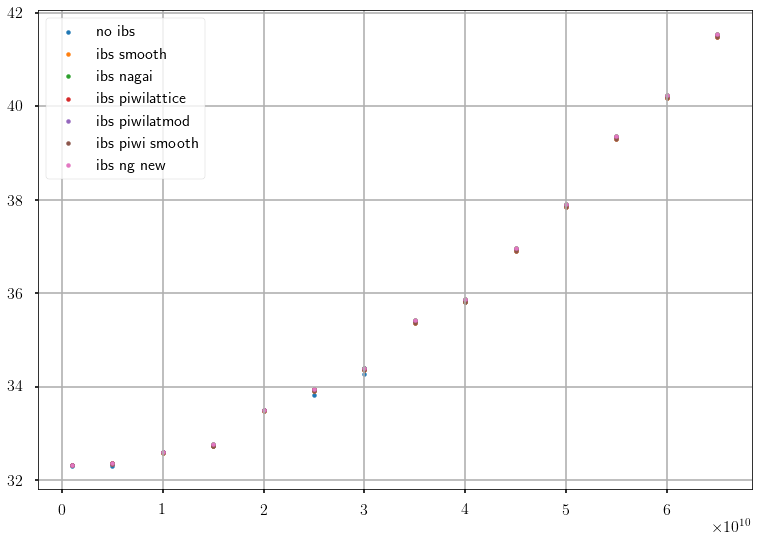

In [1276]:
fmc = len(fcon)
ssslni0 = slice(0,fmc,8) #  no ibs smooth
ssli0 = slice(1,fmc,8) # ibs smooth
sslni3 = slice(2,fmc,8) #  no ibs nagai
ssli3 = slice(3,fmc,8) # ibs nagai
ssli1 = slice(4,fmc,8) # ibs piwi lattice
ssli2 = slice(5,fmc,8) # ibs piwi lattice mod
ssli00 = slice(6,fmc,8) # ibs piwi smooth
ssli30 = slice(7,fmc,8) # nagai lower tolerances

plt.rc('text', usetex=True)
msize = 15
with plt.style.context(['seaborn-poster']):
    plt.scatter(fcon['NReal'][sslni0],fcon['sigy'][sslni0],s=msize)
    plt.scatter(fcon['NReal'][ssli0],fcon['sigy'][ssli0],s=msize)
#     plt.scatter(fcon['NReal'][sslni3],fcon['sigy'][sslni3],s=msize)
    plt.scatter(fcon['NReal'][ssli3],fcon['sigy'][ssli3],s=msize)
    plt.scatter(fcon['NReal'][ssli1],fcon['sigy'][ssli1],s=msize)
    plt.scatter(fcon['NReal'][ssli2],fcon['sigy'][ssli2],s=msize)
    plt.scatter(fcon['NReal'][ssli00],fcon['sigy'][ssli00],s=msize)
    plt.scatter(fcon['NReal'][ssli30],fcon['sigy'][ssli30],s=msize)
    plt.grid()
    plt.legend(['no ibs','ibs smooth','ibs nagai', 'ibs piwilattice', 'ibs piwilatmod','ibs piwi smooth','ibs ng new'])

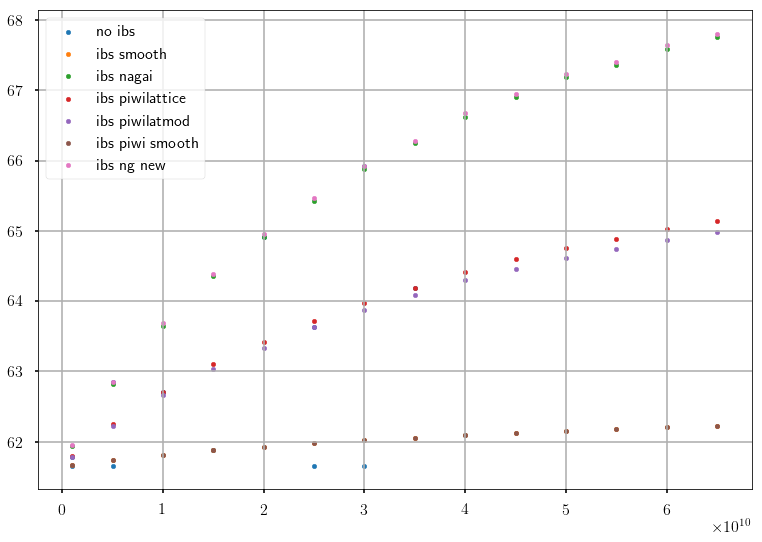

In [1277]:
fmc = len(fcon)
ssslni0 = slice(0,fmc,8) #  no ibs smooth
ssli0 = slice(1,fmc,8) # ibs smooth
sslni3 = slice(2,fmc,8) #  no ibs nagai
ssli3 = slice(3,fmc,8) # ibs nagai
ssli1 = slice(4,fmc,8) # ibs piwi lattice
ssli2 = slice(5,fmc,8) # ibs piwi lattice mod
ssli00 = slice(6,fmc,8) # ibs piwi smooth
ssli30 = slice(7,fmc,8) # nagai lower tolerances
plt.rc('text', usetex=True)
msize = 20
with plt.style.context(['seaborn-poster']):
    plt.scatter(fcon['NReal'][sslni0],fcon['sigx'][sslni0],s=msize)
    plt.scatter(fcon['NReal'][ssli0],fcon['sigx'][ssli0],s=msize)
#     plt.scatter(fmerge1['NReal'][sslni3],fmerge1['sigx'][sslni3],s=msize, label= 'no ibs')
    plt.scatter(fcon['NReal'][ssli3],fcon['sigx'][ssli3],s=msize)
    plt.scatter(fcon['NReal'][ssli1],fcon['sigx'][ssli1],s=msize)
    plt.scatter(fcon['NReal'][ssli2],fcon['sigx'][ssli2],s=msize)
    plt.scatter(fcon['NReal'][ssli00],fcon['sigx'][ssli00],s=msize)
    plt.scatter(fcon['NReal'][ssli30],fcon['sigx'][ssli30],s=msize)
    plt.grid()
    plt.legend(['no ibs','ibs smooth','ibs nagai', 'ibs piwilattice', 'ibs piwilatmod','ibs piwi smooth','ibs ng new'])

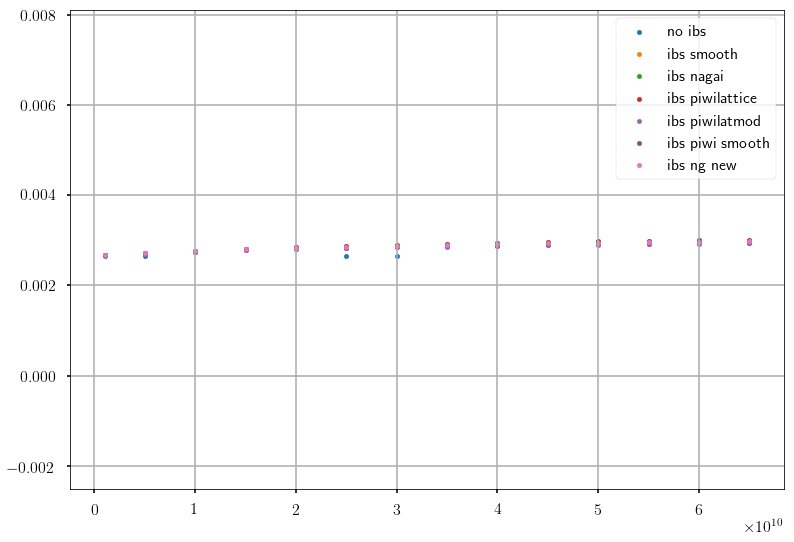

In [1279]:
fmc = len(fcon)
ssslni0 = slice(0,fmc,8) #  no ibs smooth
ssli0 = slice(1,fmc,8) # ibs smooth
sslni3 = slice(2,fmc,8) #  no ibs nagai
ssli3 = slice(3,fmc,8) # ibs nagai
ssli1 = slice(4,fmc,8) # ibs piwi lattice
ssli2 = slice(5,fmc,8) # ibs piwi lattice mod
ssli00 = slice(6,fmc,8) # ibs piwi smooth
ssli30 = slice(7,fmc,8) # nagai lower tolerances
plt.rc('text', usetex=True)
msize = 20
with plt.style.context(['seaborn-poster']):
    plt.scatter(fcon['NReal'][sslni0],fcon['sigs'][sslni0],s=msize)
    plt.scatter(fcon['NReal'][ssli0],fcon['sigs'][ssli0],s=msize)
#     plt.scatter(fmerge1['NReal'][sslni3],fmerge1['sigx'][sslni3],s=msize, label= 'no ibs')
    plt.scatter(fcon['NReal'][ssli3],fcon['sigs'][ssli3],s=msize)
    plt.scatter(fcon['NReal'][ssli1],fcon['sigs'][ssli1],s=msize)
    plt.scatter(fcon['NReal'][ssli2],fcon['sigs'][ssli2],s=msize)
    plt.scatter(fcon['NReal'][ssli00],fcon['sigs'][ssli00],s=msize)
    plt.scatter(fcon['NReal'][ssli30],fcon['sigs'][ssli30],s=msize)
    plt.grid()
    plt.legend(['no ibs','ibs smooth','ibs nagai', 'ibs piwilattice', 'ibs piwilatmod','ibs piwi smooth','ibs ng new'])

In [1030]:
legends = ['V=0.5 MV I=13 mA - BU',
           'V=1.0 MV I=13 mA - BU',
           'V=1.5 MV I=13 mA - BU',
           'V=2.0 MV I=13 mA - BU',
           'V=0.5 MV I=13 mA - ibs BU',
           'V=1.0 MV I=13 mA - ibs BU',
           'V=1.5 MV I=13 mA - ibs BU',
           'V=2.0 MV I=13 mA - ibs BU',
           'V=0.5 MV I=13 mA - BU - C',
           'V=1.0 MV I=13 mA - BU - C',
           'V=1.5 MV I=13 mA - BU - C',
           'V=2.0 MV I=13 mA - BU - C',
           'V=0.5 MV I=13 mA - ibs BU C',
           'V=1.0 MV I=13 mA - ibs BU C',
           'V=1.5 MV I=13 mA - ibs BU C' ,
           'V=2.0 MV I=13 mA - ibs BU C',
           'Rad Equil V=0.5',
           'Rad Equil V=1.0',
           'Rad Equil V=1.5',
           'Rad Equil V=2.0',
          ]
savex = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_NOIBSvsIBS_BCOUPLvsNOBCOUPL_V_2p0_ex'
savey = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_NOIBSvsIBS_BCOUPLvsNOBCOUPL_V_2p0_ey'
saves = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_NOIBSvsIBS_BCOUPLvsNOBCOUPL_V_2p0_s'
tr = float(simtest.bparams[0]['timeratio'])
ssl = slice(3,16,4)
ssll = slice(3,16,4)

In [1052]:
list(dbemitdc.keys())[ssl]

[76, 80, 84, 88]

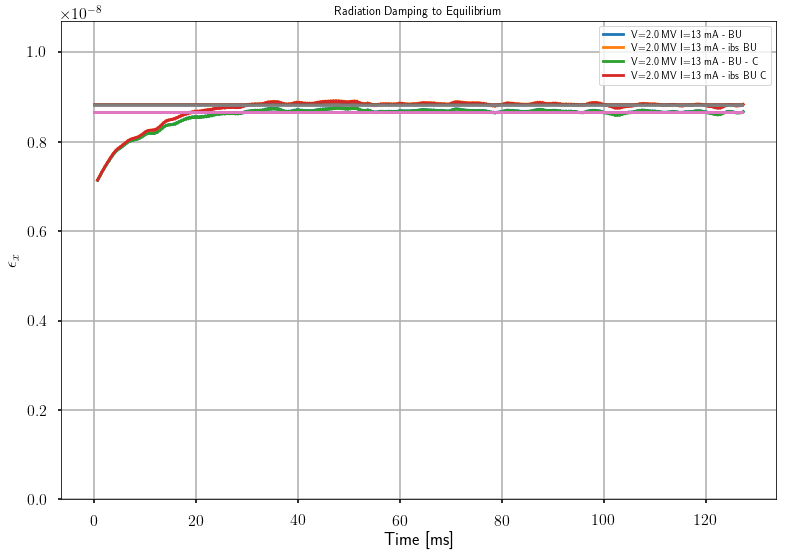

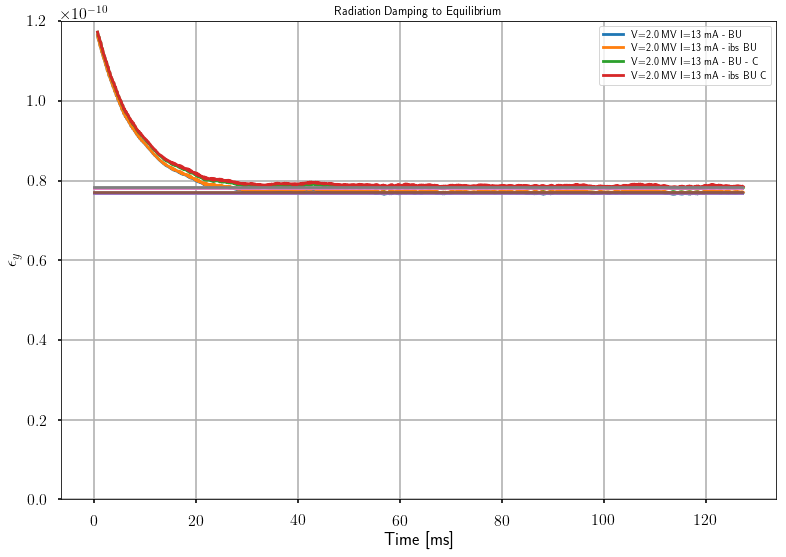

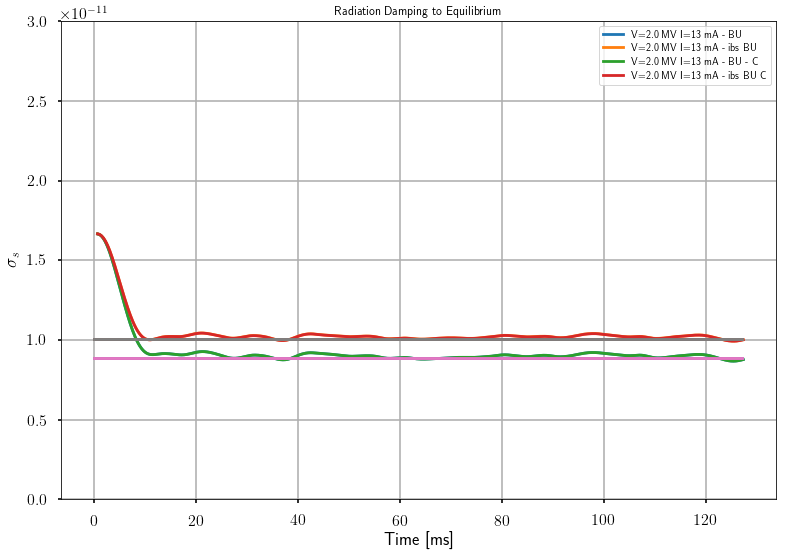

In [1054]:
sv = True
plotEmit(list(dbemitdc.values()), timeratio=tr,col='ex',n=ssl,equilib=list(dbequidc.values()), legendlabels=legends[ssll], save=sv, savefilename=savex)
plotEmit(list(dbemitdc.values()), timeratio=tr,col='ey',m=1.2e-10,n=ssl,equilib=list(dbequidc.values()), legendlabels=legends[ssll], save=sv, savefilename=savey)
plotEmit(list(dbemitdc.values()), timeratio=tr,col='sigs',m=3.0e-11,n=ssl,equilib=list(dbequidc.values()), legendlabels=legends[ssll], save=sv, savefilename=saves)

In [1168]:
ssl = slice(3,112,4)
fnpart = pd.DataFrame(pd.concat(dbintdc.values()).groupby('simid')['NReal'].max()[ssl])
fequi = pd.concat(dbequidc.values())[ssl].set_index('simid')
fmerge1 = fequi.merge(fnpart,left_index=True,right_index=True)
fmerge1['sigx'] = np.sqrt(fmerge1['equix']*betx)*1e6
fmerge1['sigy'] = np.sqrt(fmerge1['equiy']*bety)*1e6
fmerge1['sigs'] = fmerge1.equis*const.c
fmerge1 = fmerge1.sort_values(by=['NReal','id'])

In [1169]:
fmerge1

,id,date,equix,equiy,equis,NReal,sigx,sigy,sigs
simid,,,,,,,,,
92,45,2018-02-22 10:23:46.337661,8.665504e-09,4.756219e-11,8.838650e-12,1.000000e+09,61.649526,32.305072,0.002650
96,49,2018-02-22 10:25:32.193932,8.672675e-09,4.761100e-11,8.908490e-12,1.000000e+09,61.675029,32.321644,0.002671
100,53,2018-02-22 10:26:06.372530,8.665504e-09,4.756219e-11,8.838650e-12,5.000000e+09,61.649526,32.305072,0.002650
104,57,2018-02-22 10:27:50.889145,8.693059e-09,4.767421e-11,9.082270e-12,5.000000e+09,61.747466,32.343092,0.002723
108,61,2018-02-22 10:28:31.216848,8.665507e-09,4.820475e-11,8.838650e-12,1.000000e+10,61.649537,32.522559,0.002650
112,65,2018-02-22 10:30:17.990451,8.713306e-09,4.836472e-11,9.241170e-12,1.000000e+10,61.819333,32.576478,0.002770
116,69,2018-02-22 10:30:53.110356,8.665509e-09,4.863563e-11,8.838650e-12,1.500000e+10,61.649544,32.667587,0.002650
120,73,2018-02-22 10:32:40.241753,8.730277e-09,4.883172e-11,9.375220e-12,1.500000e+10,61.879506,32.733376,0.002811
124,77,2018-02-22 10:33:16.571760,8.665515e-09,5.081967e-11,8.838650e-12,2.000000e+10,61.649565,33.393021,0.002650


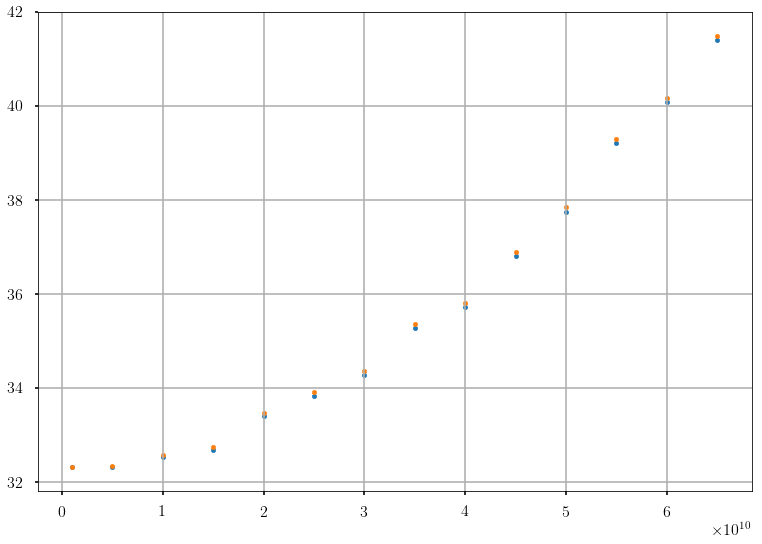

In [1170]:
sslni = slice(0,28,2)
ssli = slice(1,28,2)
plt.rc('text', usetex=True)
with plt.style.context(['seaborn-poster']):
    plt.scatter(fmerge1['NReal'][sslni],fmerge1['sigy'][sslni],s=20)
    plt.scatter(fmerge1['NReal'][ssli],fmerge1['sigy'][ssli],s=20)
    plt.grid()

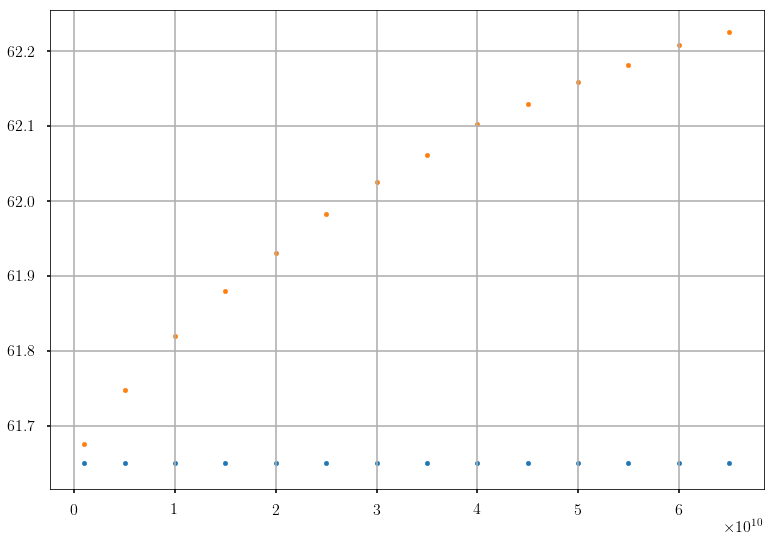

In [1171]:
sslni = slice(0,28,2)
ssli = slice(1,28,2)
plt.rc('text', usetex=True)
with plt.style.context(['seaborn-poster']):
    plt.scatter(fmerge1['NReal'][sslni],fmerge1['sigx'][sslni],s=20)
    plt.scatter(fmerge1['NReal'][ssli],fmerge1['sigx'][ssli],s=20)
    plt.grid()

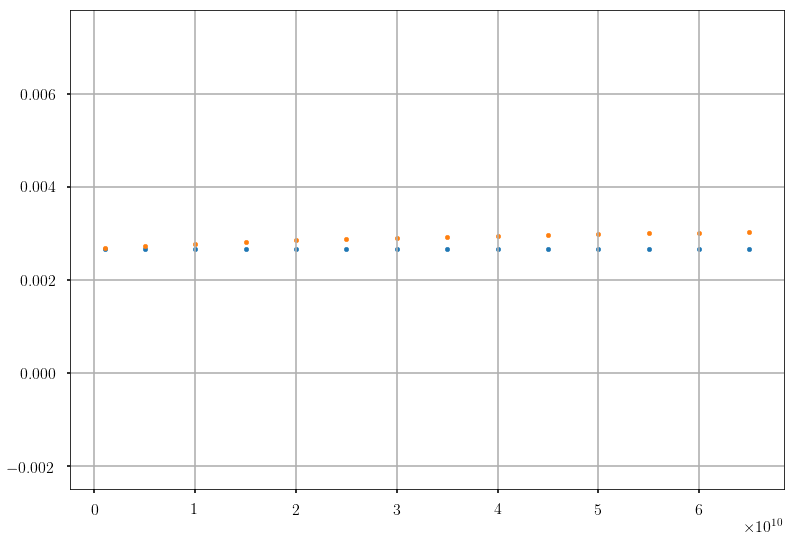

In [1172]:
sslni = slice(0,28,2)
ssli = slice(1,28,2)
plt.rc('text', usetex=True)
with plt.style.context(['seaborn-poster']):
    plt.scatter(fmerge1['NReal'][sslni],fmerge1['sigs'][sslni],s=20)
    plt.scatter(fmerge1['NReal'][ssli],fmerge1['sigs'][ssli],s=20)
    plt.grid()

(8e-09, 1e-08)

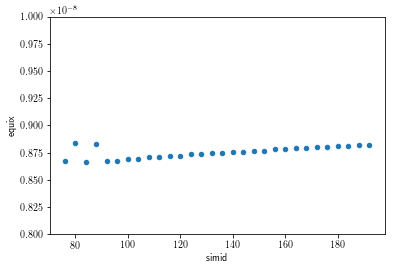

In [1067]:
pd.concat(dbequidc.values())[ssl].plot.scatter(x='simid',y='equix')
plt.ylim(0.8e-8,1e-8)

In [1061]:

leqx = (np.sqrt(pd.concat(dbequidc.values()).equix*betx).values *1e6)[ssl]
leqx

array([ 61.66834419,  62.24974547,  61.6498177 ,  62.2248901 ,
        61.66959592,  61.66959592,  61.72882149,  61.72882149,
        61.78795835,  61.78795835,  61.83952816,  61.83952816,
        61.88670368,  61.88670368,  61.93167622,  61.93167622,
        61.97406489,  61.97406489,  62.01328441,  62.01328441,
        62.05130936,  62.05130936,  62.08723064,  62.08723064,
        62.1247126 ,  62.1247126 ,  62.15643542,  62.15643542,
        62.19289895,  62.19289895])

In [1055]:
print(np.sqrt(dbequidc[76].equix*betx).values[0] *1e6, np.sqrt(dbequidc[76].equiy*bety).values[0]*1e6, dbequidc[76].equis.values[0]*const.c*2)
print(np.sqrt(dbequidc[80].equix*betx).values[0] *1e6, np.sqrt(dbequidc[80].equiy*bety).values[0]*1e6, dbequidc[80].equis.values[0]*const.c*2)

61.6683441858 41.0775078342 0.0052995212178
62.2497454679 41.1143166825 0.00604105786267


In [855]:
dbequidc[80]

,id,simid,date,equix,equiy,equis
32,33,80,2018-02-21 16:12:31.078808,8.835060e-09,7.703828e-11,1.007540e-11


In [748]:
pd.concat(list(dbequidc.values())[-2:])['equis']*2*const.c

23    0.008764
24    0.007795
Name: equis, dtype: float64

In [727]:
1.45e-11*const.c*2, 1.3e-11*const.c*2

(0.008693981282, 0.0077946039080000005)

In [939]:
infile = 'STE_BunchFile1.in'
finfile = pd.read_csv(infile, delim_whitespace=True)
finfile.loc[0,'RealNumberParticles'] = 0.5e10
finfile.to_csv(infile, sep='\t',index=False)

,BucketNumber,RealNumberParticles,emitx,emity,sigs
0,0,5.000000e+09,7.000000e-09,1.200000e-10,0.005


In [962]:
setupfile = 'STE.in'
fsetupfile = pd.read_csv(setupfile, delim_whitespace=True,names=['key','value','comment'])
fsetupfile = fsetupfile.set_index('key')
fsetupfile.loc['RFVoltage1','value'] = 0.5e6
fsetupfile.to_csv('test'+setupfile,sep='\t',header=None)

In [549]:
legends = ['I=16 mA','Rad Equil']
savex = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_Volt_0p5_ex'
savey = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_Volt_0p5_ey'
saves = '/home/tmerten/LATEX/Presentations/IPAC18/RAD_BET_RF_Volt_0p5_s'
tr = int(simtest.bparams[0]['timeratio'])

No bunchFile2 provided - returning empty frame 
Job Done


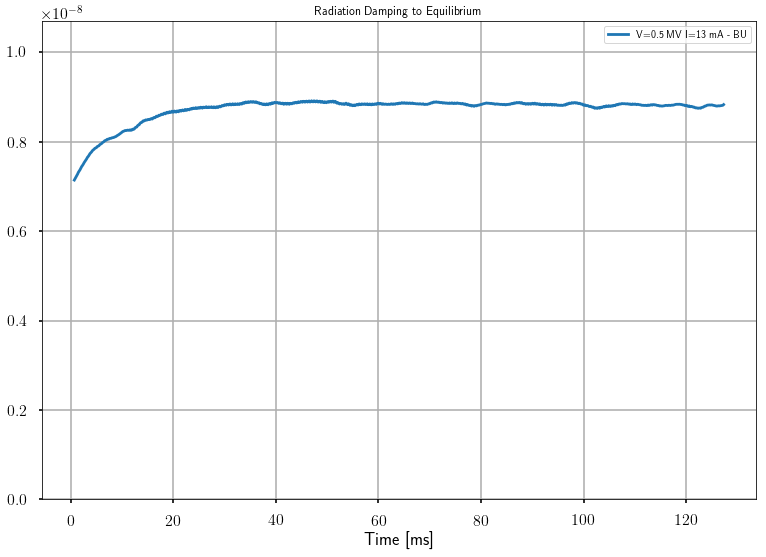

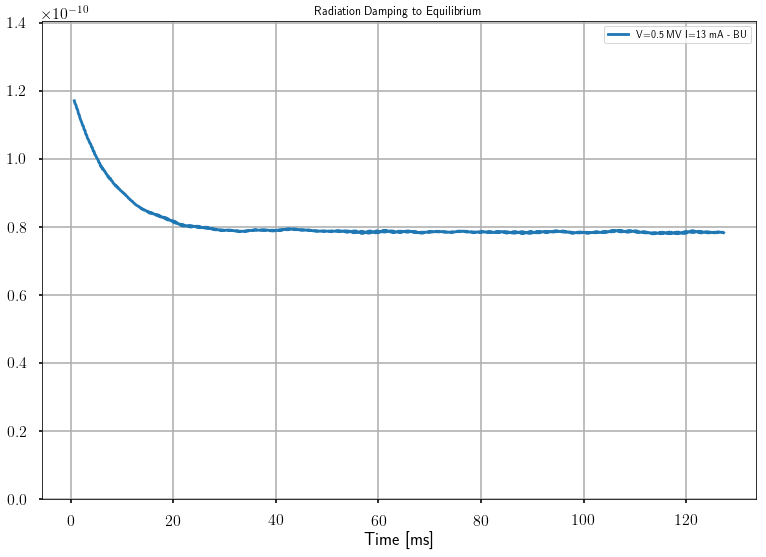

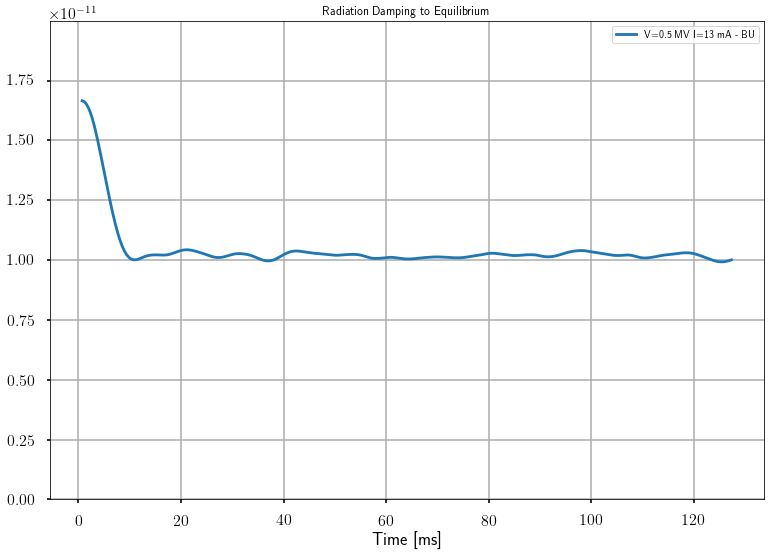

adding to database
adding to database
adding to database
adding to database


In [901]:
simtest = steSim('STE.in')
simtest.runsim()
simtest.load_distributions()
simtest.load_evolution_tables()

plotEmit(list(simtest.emit.values()),n=slice(0,1,None),col='ex',nmean=10,timeratio=tr, legendlabels=legends,save=False, savefilename=savex)
plotEmit(list(simtest.emit.values()),n=slice(0,1,None),col='ey',nmean=10,timeratio=tr, legendlabels=legends,save=False, savefilename=savey)
plotEmit(list(simtest.emit.values()),n=slice(0,1,None),col='sigs',nmean=10,timeratio=tr, legendlabels=legends,save=False, savefilename=saves)

simtest.addsimresultsdb()

In [812]:
betx= 0.438597
bety = 21.94217

In [888]:
np.sqrt(0.78e-10*bety)

4.1370149383341606e-05

In [902]:
simtest.getDBTable('equi').tail()

,id,simid,date,equix,equiy,equis
36,37,84,2018-02-21 16:43:30.113091,8.665586e-09,7.811234e-11,8.838650e-12
37,38,85,2018-02-21 16:44:28.839623,8.771718e-09,7.843456e-11,2.060080e-11
38,39,86,2018-02-21 16:45:32.609788,8.795886e-09,7.839959e-11,1.388900e-11
39,40,87,2018-02-21 16:46:12.277877,8.815369e-09,7.842742e-11,1.141200e-11
40,41,88,2018-02-21 16:47:04.285203,8.828006e-09,7.845016e-11,1.006880e-11


In [1141]:
for val in list(range(89,193)):
    values = (val, )
    simtest.engine.execute("delete from equi where simid=?", values)
    simtest.engine.execute("delete from ibs where simid=?", values)
    simtest.engine.execute("delete from emit where simid=?", values)
    simtest.engine.execute("delete from intensity where simid=?", values)

In [884]:
simtest.engine.execute("delete from equi where simid=?", values)
simtest.engine.execute("delete from ibs where simid=?", values)
simtest.engine.execute("delete from emit where simid=?", values)
simtest.engine.execute("delete from intensity where simid=?", values)


In [814]:
simtest.getDBTable('equi').tail()

,id,simid,date,equix,equiy,equis
25,26,73,2018-02-21 15:50:50.891479,8.671362e-09,8.841050e-11,1.916030e-11
26,27,74,2018-02-21 15:53:51.241127,8.670795e-09,8.831850e-11,1.251350e-11
27,28,75,2018-02-21 15:54:48.491910,8.670795e-09,8.831850e-11,1.011300e-11
28,29,76,2018-02-21 15:55:31.598953,8.670795e-09,8.831850e-11,8.838650e-12
29,30,77,2018-02-21 15:56:52.230977,8.772821e-09,8.848465e-11,2.053920e-11


In [800]:
np.sqrt(0.841e-10*20)

4.1012193308819757e-05

In [770]:
simtest.addsimresultsdb()

Already saved to db


In [571]:
simtest.bparams

OrderedDict([(0,
              OrderedDict([('Bucket', '0'),
                           ('Energy', 'lost'),
                           ('tunex', '17.8445'),
                           ('tuney', '6.7241'),
                           ('trev', '8.00582e-07'),
                           ('timeratio', '200'),
                           ('particleType', 'electron'),
                           ('particleAtomNumber', '1'),
                           ('particleCharge', '-1'),
                           ('methodRadiationIntegrals', '2'),
                           ('tfsfile',
                            '/home/tmerten/mad/2018-02-14/madin/here.tfs'),
                           ('numberMacroParticles', '20000'),
                           ('methodLongitudinalDist', '2'),
                           ('acceleratorLength', '240.008'),
                           ('betxRingAverage', '2.14064'),
                           ('betyRingAverage', '5.68084'),
                           ('gammaTransition', '37

In [428]:
float(simtest.getEquilibRadvalues(0)[2])*const.c

0.0053564817848234005

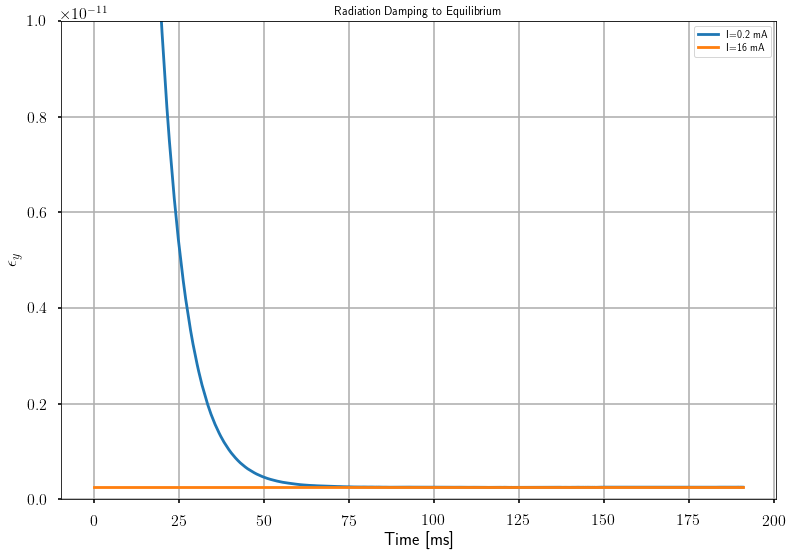

In [418]:
plotEmit(list(simtest.emit.values()),equilib=simtest.getEquilibRadvalues(0),n=1,m=1e-11,col='ey',nmean=10,timeratio=200, legendlabels=['I=0.2 mA','I=16 mA','Rad Equil'],save=False, savefilename='/home/tmerten/LATEX/Presentations/IPAC18/RAD_ex')
plt.show()

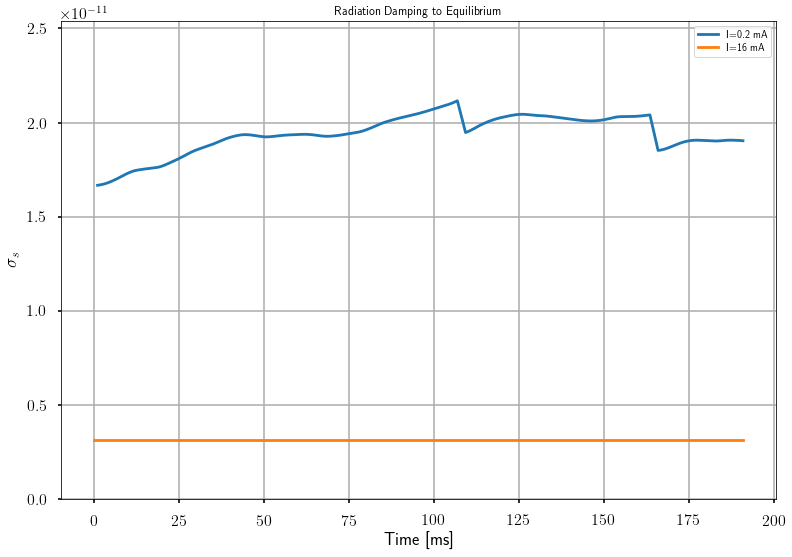

In [386]:
plotEmit(list(simtest.emit.values()),equilib=simtest.getEquilibRadvalues(0),n=1,col='sigs',nmean=10,timeratio=300, legendlabels=['I=0.2 mA','I=16 mA','Rad Equil'],save=False, savefilename='/home/tmerten/LATEX/Presentations/IPAC18/RAD_ex')

In [399]:
simtest.getEquilibRadtimes(0)

['0.00795572', '0.0078924', '0.00393056']

In [398]:
simtest.getEquilibRadvalues(0)

['8.66796e-09', '2.5505e-13', '3.15086e-12']

In [393]:
float(simtest.bparams[0]['omegas'])

27493.9

In [396]:
np.sqrt(1.65e-15*const.c) / float(simtest.bparams[0]['omegas']) * float(simtest.bparams[0]['eta'])

1.7862279088788909e-11

In [387]:
1.5e-11*const.c

0.00449688687

In [402]:
simtest = steSim('STE.in')

No bunchFile2 provided - returning empty frame 


In [403]:
simtest.runsim()

Job Done


In [404]:
simtest.load_distributions()

In [405]:
simtest.load_evolution_tables()

In [406]:
simtest.getDBTableNames()

['emit', 'ibs', 'intensity']

In [360]:
simtest.getDBTableColumns('ibs')

['id', 'simid', 'date', 'Turn', 'Tex', 'Tey', 'Tp']

In [361]:
simtest.getDBTable('ibs').head()

,id,simid,date,Turn,Tex,Tey,Tp
0,1,1,2018-02-16 12:18:06.638618,0,3.26523,100.0330,0.287330
1,2,2,2018-02-16 16:39:53.490653,0,3.31689,99.9723,0.289581
2,3,3,2018-02-16 16:48:50.119835,0,3.31689,99.9723,0.289581
3,4,4,2018-02-16 16:53:52.566355,0,3.31689,99.9723,0.289581
4,5,5,2018-02-16 16:58:48.231453,0,3.31689,99.9723,0.289581


In [334]:
simtest.dblastid

46

In [337]:
simtest.addedtodb

True

In [338]:
simtest.addsimresultsdb()

In [350]:
list(simtest.emit.values())

[     Turn            ex     sigpx            ey     sigpy          sigs  \
 0       0  6.977300e-09  0.000123  1.206980e-10  0.000026  1.664390e-11   
 1       1  7.103280e-09  0.000123  1.161700e-10  0.000026  1.664690e-11   
 2       2  7.188800e-09  0.000123  1.141490e-10  0.000025  1.665150e-11   
 3       3  7.086230e-09  0.000124  1.089090e-10  0.000025  1.665730e-11   
 4       4  7.153890e-09  0.000124  1.076440e-10  0.000024  1.666460e-11   
 5       5  7.290010e-09  0.000124  1.025240e-10  0.000024  1.667210e-11   
 6       6  7.244290e-09  0.000125  1.011060e-10  0.000024  1.668000e-11   
 7       7  7.283900e-09  0.000125  9.684790e-11  0.000024  1.668630e-11   
 8       8  7.405390e-09  0.000125  9.467690e-11  0.000023  1.669390e-11   
 9       9  7.436320e-09  0.000126  9.167680e-11  0.000023  1.670270e-11   
 10     10  7.404240e-09  0.000127  8.856720e-11  0.000023  1.671130e-11   
 11     11  7.598360e-09  0.000126  8.675420e-11  0.000022  1.672110e-11   
 12     12  

In [351]:
simtest.getDBTableColumns('ibs')

['id', 'simid', 'date', 'Turn', 'Tex', 'Tey', 'Tp']